In [107]:
import numpy as np
import pandas as pd
import os
import torch 
import torchvision
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torchvision import models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [108]:

allVectors = np.load('allVectorsFirst.npy', allow_pickle='TRUE').item()
X_data = pd.read_csv('train_triplets.txt', delimiter=' ', dtype=str)
X_data = X_data.to_numpy()
print('loaded')
n =X_data.shape[0]
print(n)
n_test = int(0.2*n)
print(n_test)



X_test = X_data[0:n_test,:]
X_data = X_data[n_test:n,:]

print(X_data.shape)
print(X_test.shape)

loaded
59514
11902
(47612, 3)
(11902, 3)


In [109]:
def test_prediction(img1, img2, img3):
    if (F.cosine_similarity(img1, img3, 0)  > F.cosine_similarity(img1, img2, 0)):
        return 0
    else:
        return 1

In [110]:
class CustomImageDataset(Dataset):
    def __init__(self,labels, triplets, image_dictionary):
        self.labels = labels
        self.triplets = triplets
        self.image_dictionary = image_dictionary


    def __len__(self):
        return self.triplets.shape[0]

    def __getitem__(self, idx):
        if self.labels[idx]==1:
            anchor = self.image_dictionary[self.triplets[idx, 0] + '.jpg']
            positive = self.image_dictionary[self.triplets[idx, 1] + '.jpg']
            negative = self.image_dictionary[self.triplets[idx, 2] + '.jpg']
        elif self.labels[idx]==0:
            anchor = self.image_dictionary[self.triplets[idx, 0] + '.jpg']
            negative = self.image_dictionary[self.triplets[idx, 1] + '.jpg']
            positive = self.image_dictionary[self.triplets[idx, 2] + '.jpg']

        else:
            print('LABEL ERROR at Index' + str(idx))
        return anchor, positive, negative
        #return torch.Tensor(anchor, requires_grad=True), torch.Tensor(positive, requires_grad=True), torch.Tensor(negative, requires_grad=True)

In [111]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self, input_dim: int, ouput_dim: int):
        super().__init__()    # initialize the torch.nn.Module first

        # then we attach different layers/activations to self
        self.fc1 = torch.nn.Linear(input_dim, 512) # Wx+b
        self.fc2 = torch.nn.Linear(512, 512)
        self.fc3 = torch.nn.Linear(512, 500)
        self.fc_out = torch.nn.Linear(500, ouput_dim)
        #self.activation_fn = torch.nn.ReLU()
        self.activation_fn = torch.nn.Tanh()

    def forward(self, a: torch.Tensor, p: torch.Tensor, n: torch.Tensor) -> torch.Tensor:
        resulta = self.fc1(a)
        resulta = self.activation_fn(resulta)
        resulta = self.fc2(resulta)
        resulta = self.activation_fn(resulta)
        resulta = self.fc3(resulta)
        resulta = self.activation_fn(resulta)
        resulta = self.fc_out(resulta)
        
        resultp = self.fc1(p)
        resultp = self.activation_fn(resultp)
        resultp = self.fc2(resultp)
        resultp = self.activation_fn(resultp)
        resultp = self.fc3(resultp)
        resultp = self.activation_fn(resultp)
        resultp = self.fc_out(resultp)
        
        resultn = self.fc1(n)
        resultn = self.activation_fn(resultn)
        resultn = self.fc2(resultn)
        resultn = self.activation_fn(resultn)
        resultn = self.fc3(resultn)
        resultn = self.activation_fn(resultn)
        resultn = self.fc_out(resultn)
        return resulta, resultp, resultn


In [112]:
def triplet_loss(anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor, margin=0.0) -> torch.Tensor:
  
  #return torch.mean(torch.clamp(F.pairwise_distance(anchor, positive, keepdim = True)**2 - F.pairwise_distance(anchor, negative, keepdim = True)**2 + margin, min=0.0))
  return torch.mean(torch.clamp(-F.cosine_similarity(anchor, positive) + F.cosine_similarity(anchor, negative) + margin, min=0.0))


In [113]:
testset = CustomImageDataset(np.ones(X_data.shape[0]), X_data, allVectors)

In [114]:
train_dataloader = DataLoader(testset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1000)

In [115]:
net = SiameseNetwork(512, 1000)
#for name, param in net.named_parameters():
    #print(name, param.shape, param.requires_grad)
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0 )

0.9688929319381714
accuracy: 0.6619895815829272


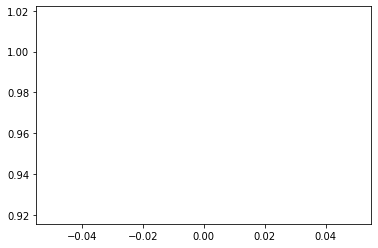

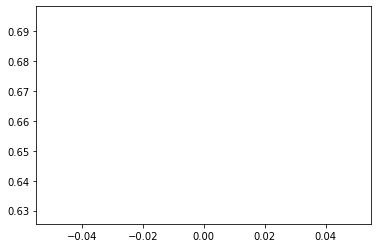

0.9005252122879028
0.800032913684845
0.7586137056350708
0.6922367215156555
0.7352519631385803
accuracy: 0.6870273903545623
0.722249448299408
0.7231407761573792
0.7395698428153992
0.7019634246826172
0.7336130738258362
accuracy: 0.6946731641740884


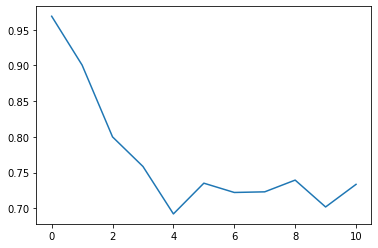

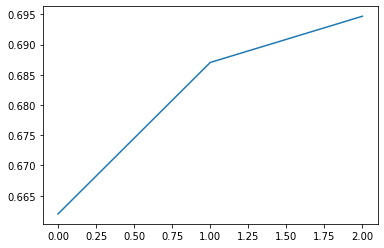

0.7189842462539673
0.7127166390419006
0.7461272478103638
0.7028709650039673
0.7106671333312988
accuracy: 0.7019828600235255
0.6998321413993835
0.6811220645904541
0.6840206384658813
0.6799823045730591
0.6823928952217102
accuracy: 0.7124852965888087


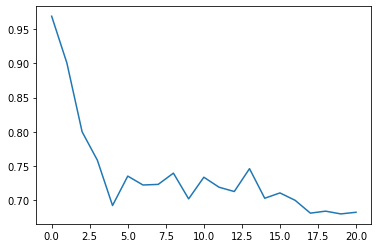

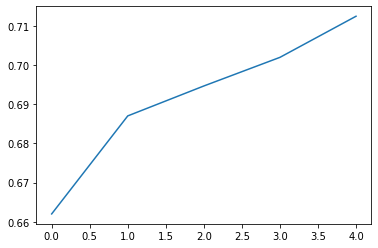

0.6661397814750671
0.6813839673995972
0.6633493900299072
0.68370121717453
0.6421850323677063
accuracy: 0.7082003024701731
0.6582706570625305
0.6581129431724548
0.7104812264442444
0.6957336664199829
0.674776554107666
accuracy: 0.7176945051251891


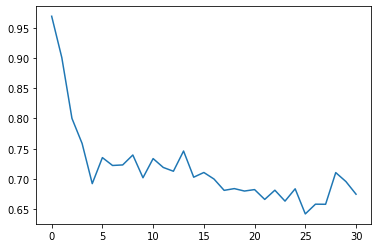

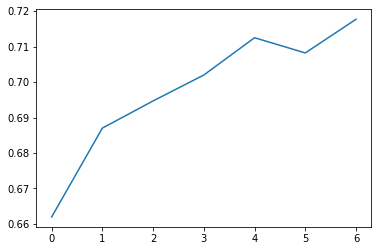

0.6890609264373779
0.6724972128868103
0.6889622807502747
0.6355738043785095
0.6795162558555603
accuracy: 0.7124012770962863
0.6560038924217224
0.6424960494041443
0.6554584503173828
0.6325297355651855
0.6480926275253296
accuracy: 0.7155940178121324


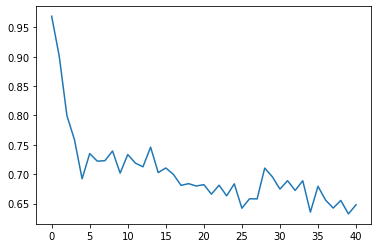

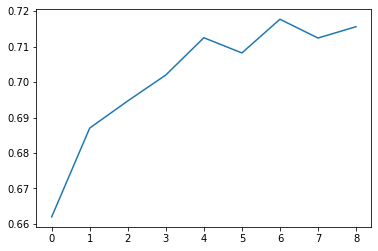

0.6471194624900818
0.660798966884613
0.6408424973487854
0.6187094449996948
0.6485400795936584
accuracy: 0.7176104856326668
0.6216538548469543
0.6626825928688049
0.6259191036224365
0.6282588243484497
0.6734379529953003
accuracy: 0.7231557721391363


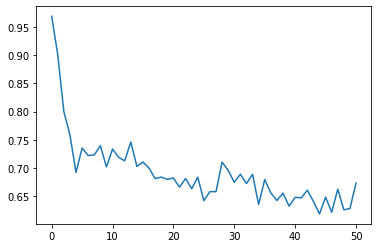

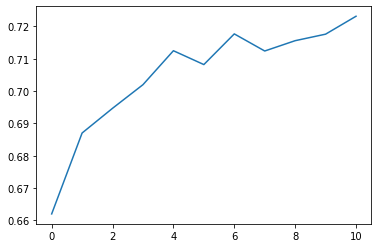

0.6390743851661682
0.6428653001785278
0.6461174488067627
0.6898232102394104
0.6396365165710449
accuracy: 0.7247521424970593
0.6727635264396667
0.6732227802276611
0.6577752232551575
0.6525378227233887
0.6393994092941284
accuracy: 0.7237439085867922


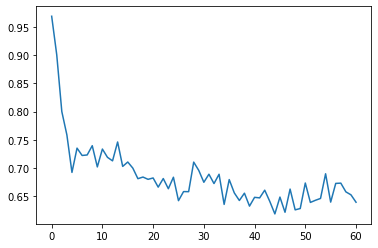

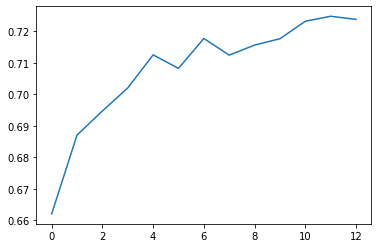

0.6347087621688843
0.6327227354049683
0.6620221734046936
0.657954216003418
0.6103463172912598
accuracy: 0.725256259452193
0.6337619423866272
0.6465616226196289
0.666317880153656
0.6563084721565247
0.6379105448722839
accuracy: 0.7297933120483953


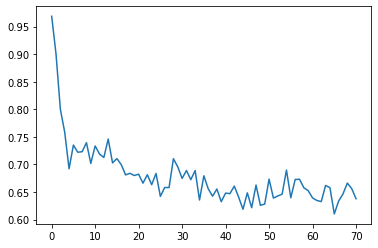

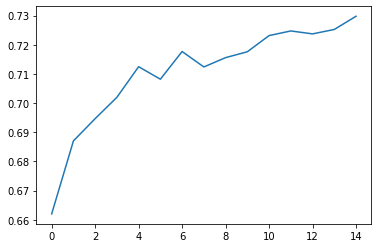

0.6288952231407166
0.6281691789627075
0.6388323307037354
0.6518030166625977
0.6523138284683228
accuracy: 0.7324819358091077
0.6162219047546387
0.6413146257400513
0.6445825695991516
0.5966848134994507
0.6284098625183105
accuracy: 0.7293732145857839


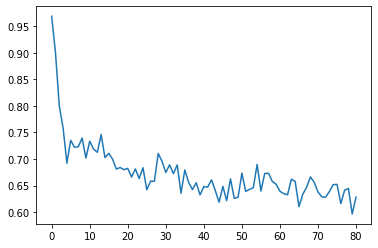

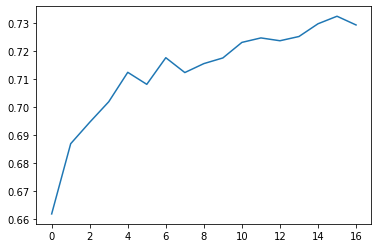

0.6428457498550415
0.606915295124054
0.6340615749359131
0.6488108038902283
0.6314345002174377
accuracy: 0.7302974290035288
0.6199198961257935
0.6382055282592773
0.6490830183029175
0.6264097690582275
0.6413828134536743
accuracy: 0.7265165518400268


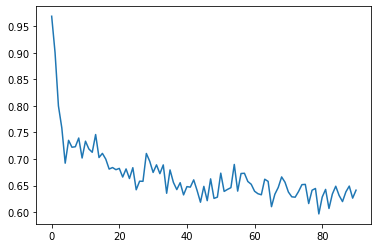

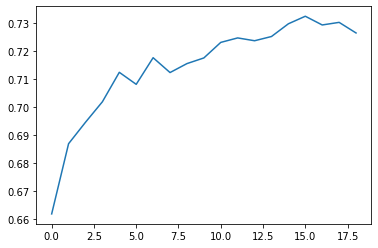

0.5911503434181213
0.6212419271469116
0.6472048163414001
0.6734970808029175
0.6076042056083679
accuracy: 0.7313896824063183
0.591554582118988
0.6054534912109375
0.632261335849762
0.6375369429588318
0.6084761023521423
accuracy: 0.7329860527642413


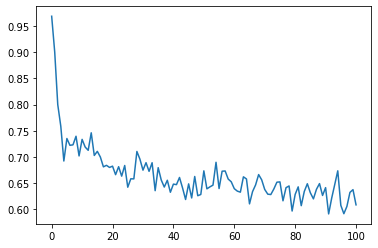

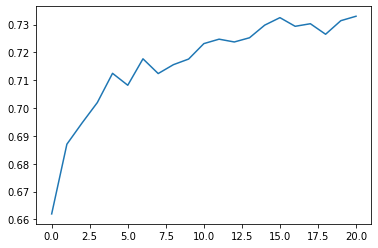

0.6077631115913391
0.6180980205535889
0.6260192394256592
0.623338520526886
0.6004469990730286
accuracy: 0.7302134095110066
0.6443039774894714
0.6050387024879456
0.6078007817268372
0.6207152605056763
0.5934109687805176
accuracy: 0.7361787934800874


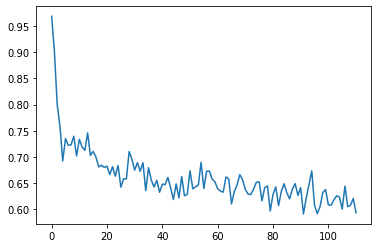

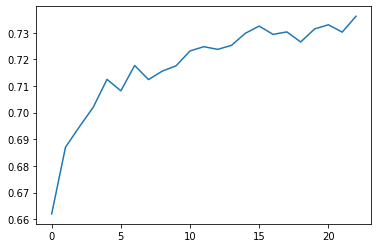

0.6295722723007202
0.635612428188324
0.6640466451644897
0.6689167022705078
0.6019598841667175
accuracy: 0.728449000168039
0.612492024898529
0.6281296610832214
0.6572192311286926
0.6159319877624512
0.6431436538696289
accuracy: 0.7299613510334397


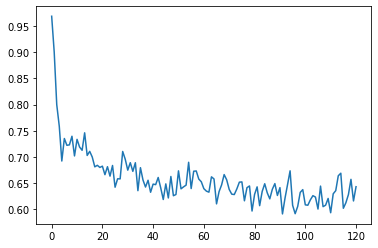

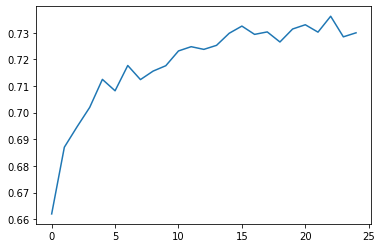

0.6414135694503784
0.6214838624000549
0.6256526708602905
0.6207714676856995
0.6104496121406555
accuracy: 0.734498403629642
0.5730857253074646
0.6177172660827637
0.6029384732246399
0.5689520835876465
0.6140088438987732
accuracy: 0.7403797681062007


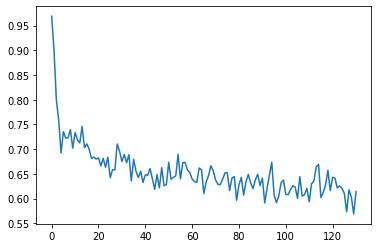

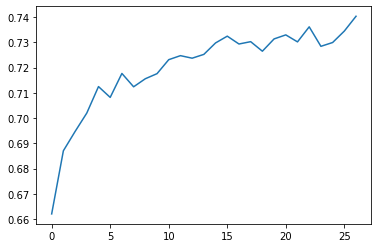

0.6261504888534546
0.5981097221374512
0.62815260887146
0.6025205254554749
0.590164303779602
accuracy: 0.7320618383464964
0.6101003289222717
0.5810256600379944
0.5941182374954224
0.5955266952514648
0.5952842235565186
accuracy: 0.7384473197781886


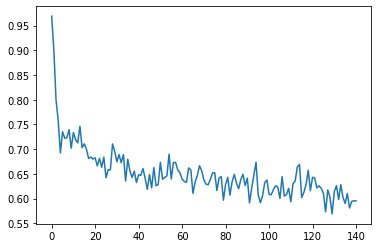

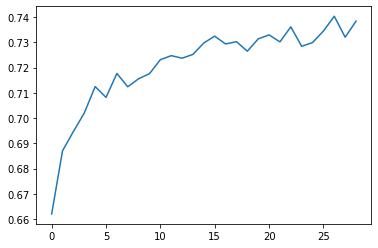

0.6089931726455688
0.630483090877533
0.6399442553520203
0.6137121915817261
0.6044601798057556
accuracy: 0.7348344815997312
0.6362159848213196
0.6221427321434021
0.6219724416732788
0.5957382917404175
0.5766457915306091
accuracy: 0.735422618047387


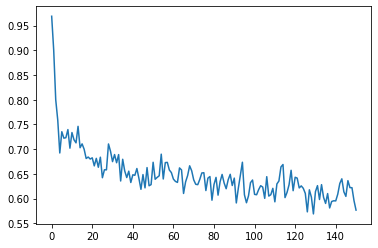

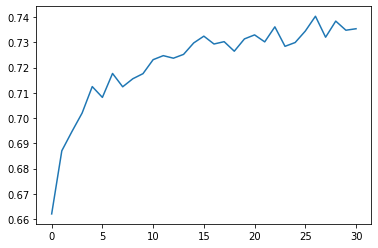

0.6151623725891113
0.61467045545578
0.6449918746948242
0.602029025554657
0.6290256381034851
accuracy: 0.7325659553016299
0.6113712191581726
0.635049045085907
0.6188347339630127
0.6289694905281067
0.5770841240882874
accuracy: 0.7308015459586624


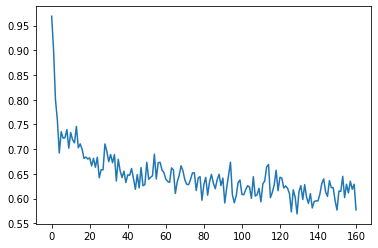

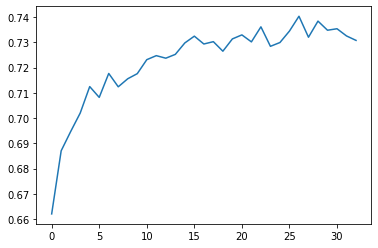

0.6393177509307861
0.6523348093032837
0.6454836130142212
0.6294534206390381
0.6347467303276062
accuracy: 0.7317257603764074
0.6228216290473938
0.5956833362579346
0.6125021576881409
0.6297652721405029
0.6330282688140869
accuracy: 0.726852629810116


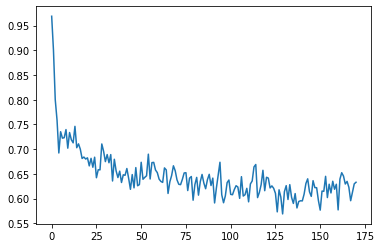

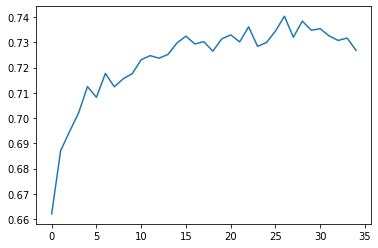

0.6335066556930542
0.6265997290611267
0.6051011681556702
0.6388558149337769
0.6002829670906067
accuracy: 0.7359267350025206
0.6063891649246216
0.6152496337890625
0.6123288869857788
0.6091707944869995
0.6061062216758728
accuracy: 0.7376911443454881


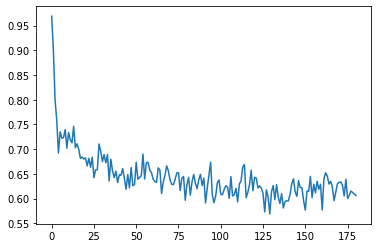

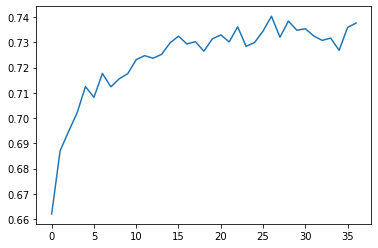

0.5744629502296448
0.5771349668502808
0.6147637963294983
0.606282114982605
0.5814675688743591
accuracy: 0.7375231053604436
0.6052791476249695
0.5624222159385681
0.6044268608093262
0.6025092601776123
0.5965904593467712
accuracy: 0.7392034952108889


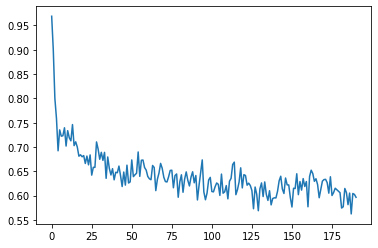

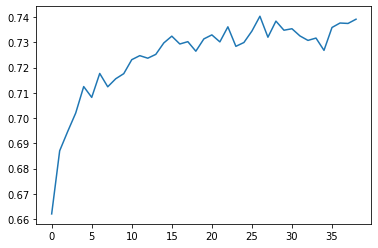

0.539459228515625
0.5647838115692139
0.5949309468269348
0.6323673725128174
0.574180006980896
accuracy: 0.7412199630314233
0.6006752252578735
0.5842928886413574
0.6184186339378357
0.5749031901359558
0.5851172804832458
accuracy: 0.7400436901361116


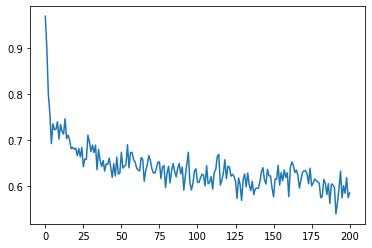

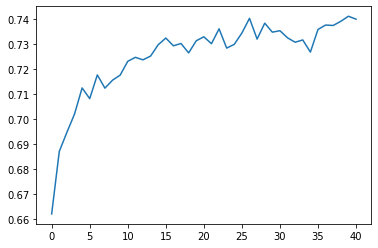

0.602266788482666
0.6211997270584106
0.6110760569572449
0.6133428812026978
0.5919206142425537
accuracy: 0.7388674172407999
0.574052095413208
0.6245540380477905
0.5740873217582703
0.5928838849067688
0.5680066347122192
accuracy: 0.7402957486136784


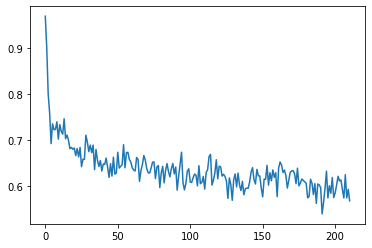

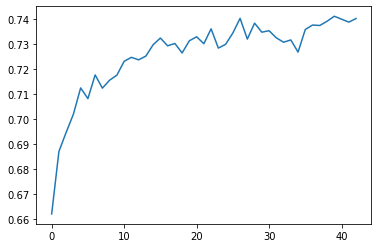

0.6159403324127197
0.60338294506073
0.5725932717323303
0.6006399989128113
0.5911500453948975
accuracy: 0.7394555536884557
0.5745607018470764
0.5926417708396912
0.5691035389900208
0.6130326986312866
0.6074430346488953
accuracy: 0.7404637875987229


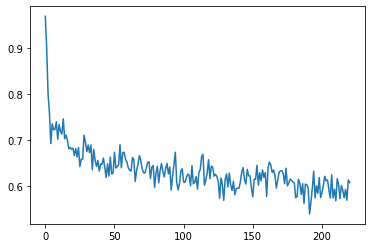

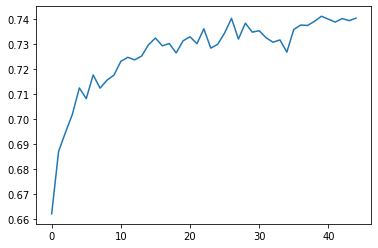

0.5778183341026306
0.6150493025779724
0.5821913480758667
0.6133267879486084
0.6036033034324646
accuracy: 0.7455049571500588
0.5933857560157776
0.5650174617767334
0.5704004168510437
0.5578112602233887
0.5896730422973633
accuracy: 0.7448328012098807


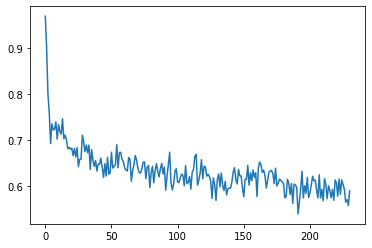

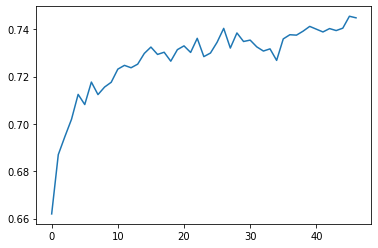

0.5686151385307312
0.5207602381706238
0.5474414825439453
0.5768429040908813
0.5612193942070007
accuracy: 0.749033775835994
0.6130720973014832
0.5723572373390198
0.5850547552108765
0.5687940120697021
0.5848839282989502
accuracy: 0.7472693664930263


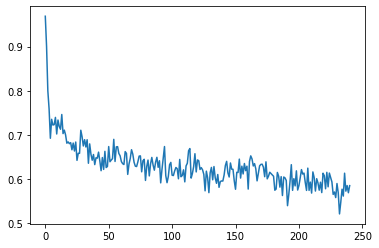

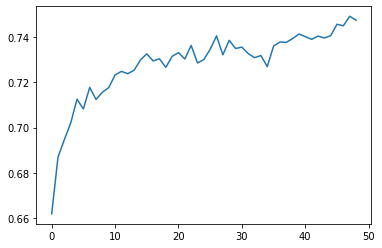

0.5755406618118286
0.5933827757835388
0.5478987097740173
0.5969927906990051
0.585757315158844
accuracy: 0.743656528314569
0.6022243499755859
0.5696752667427063
0.6058502197265625
0.5856961011886597
0.5935115814208984
accuracy: 0.7434884893295245


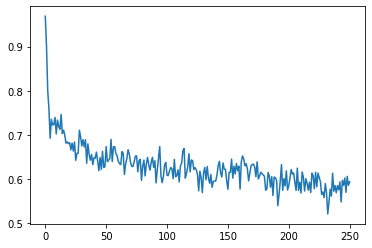

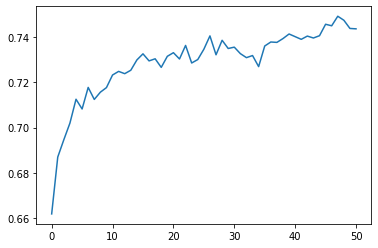

0.5976276397705078
0.5966223478317261
0.5701606273651123
0.6085314750671387
0.5833501815795898
accuracy: 0.7420601579566459
0.5919069647789001
0.5978114008903503
0.6344719529151917
0.6029375195503235
0.5744268298149109
accuracy: 0.7356746765249538


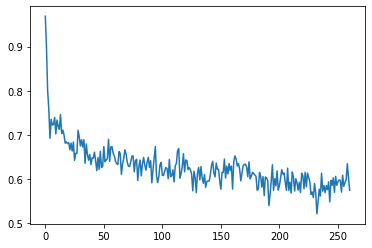

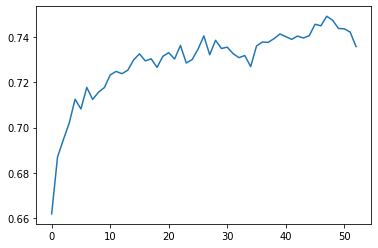

0.607559859752655
0.5940505862236023
0.5467780828475952
0.5694695115089417
0.5634818077087402
accuracy: 0.7415560410015124
0.582870364189148
0.5478661060333252
0.609706699848175
0.5653935074806213
0.61931312084198
accuracy: 0.737355066375399


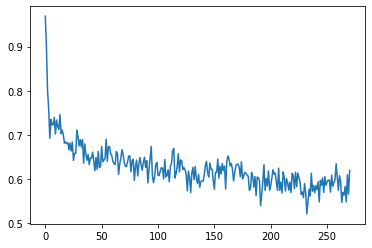

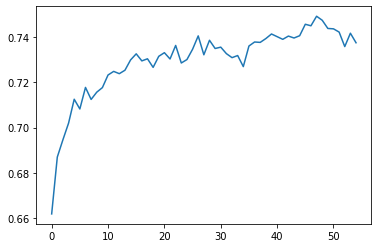

0.5877646803855896
0.5880823731422424
0.6150543093681335
0.571405291557312
0.6380578875541687
accuracy: 0.746513191060326
0.6001009941101074
0.587810754776001
0.5828564167022705
0.597859799861908
0.616270899772644
accuracy: 0.7443286842547471


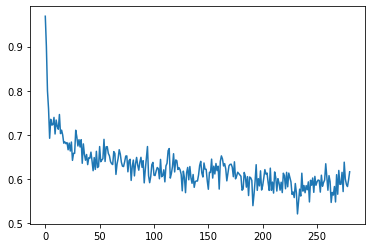

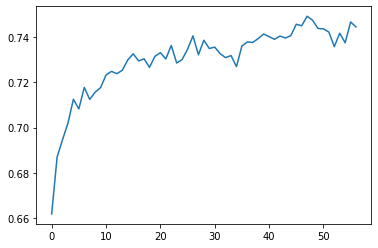

0.6165284514427185
0.5871814489364624
0.5652332305908203
0.6077657341957092
0.5870916843414307
accuracy: 0.7352545790623425
0.5988521575927734
0.5808867812156677
0.5485399961471558
0.5433085560798645
0.5611616969108582
accuracy: 0.745252898672492


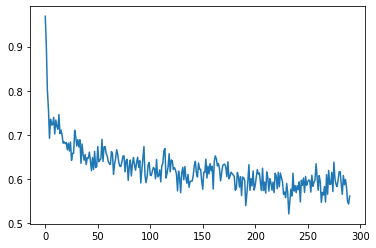

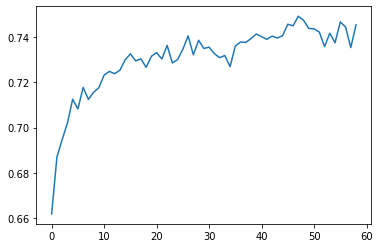

0.5868851542472839
0.5939487218856812
0.582339346408844
0.5745676159858704
0.592766284942627
accuracy: 0.7525625945219291
0.6087338924407959
0.5864924192428589
0.5243787169456482
0.5887928605079651
0.5550186038017273
accuracy: 0.7474374054780709


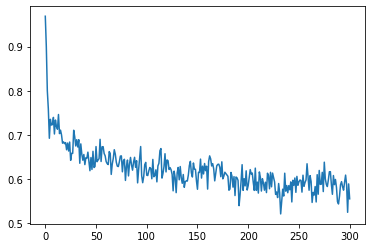

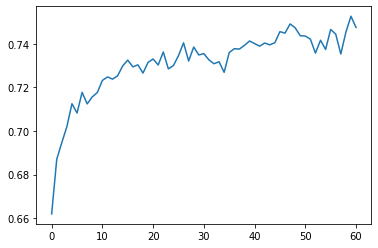

0.5822333097457886
0.5372090935707092
0.5917999148368835
0.5846887826919556
0.5451854467391968
accuracy: 0.7483616198958158
0.6083077192306519
0.5522469878196716
0.6116052269935608
0.5722346901893616
0.6012235879898071
accuracy: 0.7546630818349858


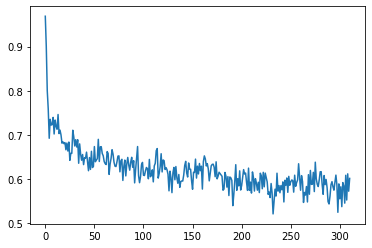

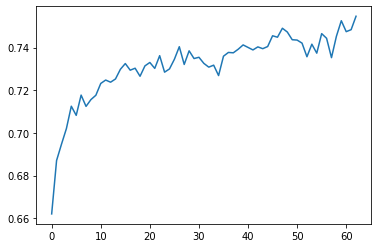

0.5467864871025085
0.5369119644165039
0.5524015426635742
0.5864513516426086
0.5985391736030579
accuracy: 0.7508822046714838
0.57774817943573
0.6059672832489014
0.5947727560997009
0.5682422518730164
0.5710321068763733
accuracy: 0.7530667114770627


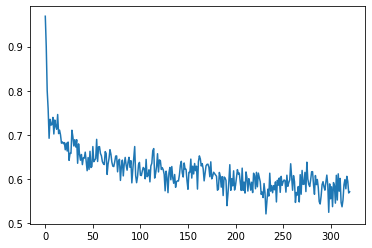

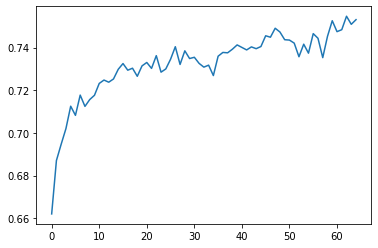

0.5670968294143677
0.5897536873817444
0.5716785788536072
0.5711544156074524
0.5631773471832275
accuracy: 0.749369853806083
0.6212857961654663
0.5796467661857605
0.5703580379486084
0.571068286895752
0.5597916841506958
accuracy: 0.7543270038648967


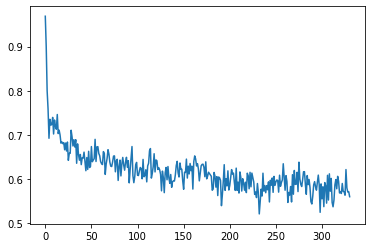

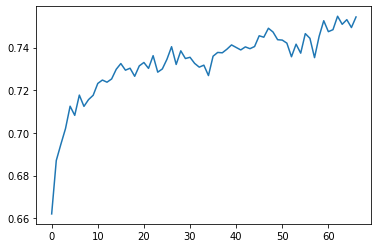

0.5741305947303772
0.605874240398407
0.5572385787963867
0.5358739495277405
0.5556667447090149
accuracy: 0.7561754327003865
0.566115140914917
0.5821239352226257
0.5625017285346985
0.5668618679046631
0.5879086852073669
accuracy: 0.7507141656864392


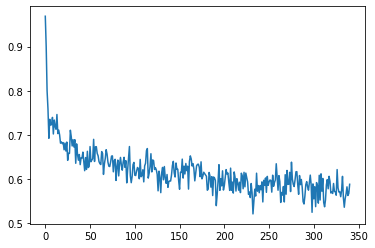

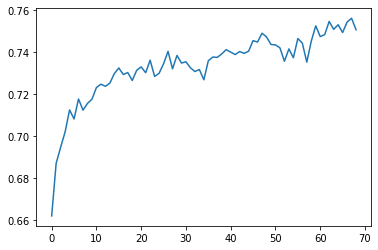

0.5746675133705139
0.5543590188026428
0.6032692193984985
0.5523812174797058
0.5629186630249023
accuracy: 0.7444967232397917
0.5818711519241333
0.545167863368988
0.5581899881362915
0.5397894382476807
0.5554951429367065
accuracy: 0.7557553352377752


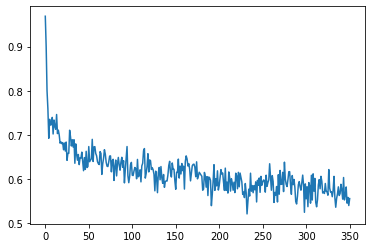

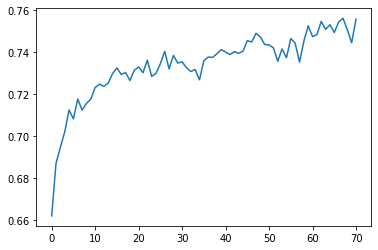

0.5704591274261475
0.5302249193191528
0.5420518517494202
0.5546765327453613
0.5347238779067993
accuracy: 0.7587800369685767
0.5381899476051331
0.5728853940963745
0.574554443359375
0.5811589360237122
0.5721323490142822
accuracy: 0.7581919005209209


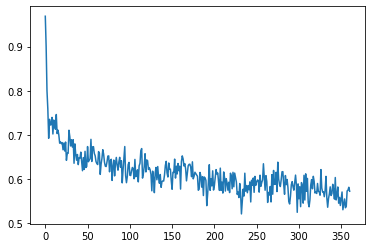

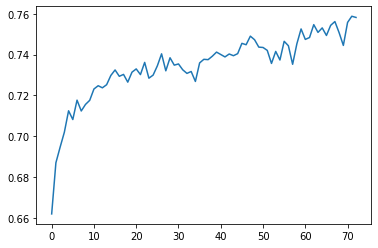

0.5476043820381165
0.5403534770011902
0.569402277469635
0.5512022972106934
0.5637309551239014
accuracy: 0.757267686103176
0.5367684364318848
0.5361250042915344
0.5648264288902283
0.5488954782485962
0.5862906575202942
accuracy: 0.7587800369685767


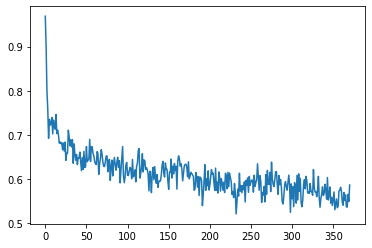

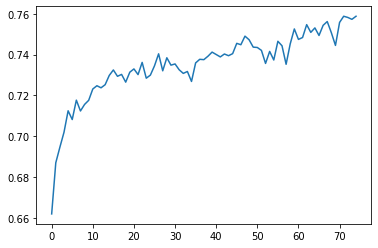

0.5408497452735901
0.5895152688026428
0.5336598753929138
0.5613368153572083
0.5365399718284607
accuracy: 0.750966224164006
0.5915985703468323
0.5614696145057678
0.5740146636962891
0.5456188321113586
0.5674651265144348
accuracy: 0.7553352377751639


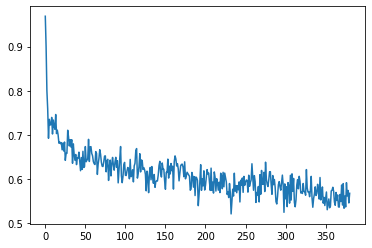

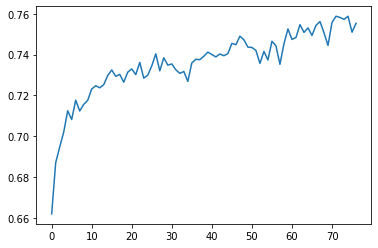

0.5496346354484558
0.5408226847648621
0.5542253255844116
0.5571075081825256
0.5515816807746887
accuracy: 0.7503780877163502
0.5579156279563904
0.530174970626831
0.6013385057449341
0.5505865216255188
0.540020763874054
accuracy: 0.7459250546126701


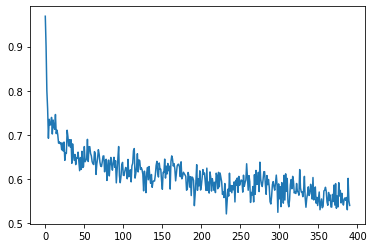

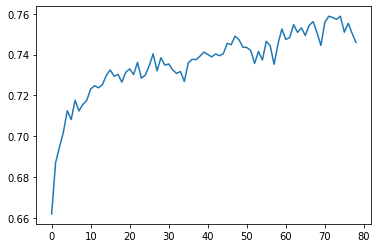

0.5757147669792175
0.5916492938995361
0.5733655691146851
0.5582582354545593
0.6240578889846802
accuracy: 0.756343471685431
0.520100474357605
0.5848874449729919
0.554660439491272
0.5957989692687988
0.5760381817817688
accuracy: 0.7560914132078642


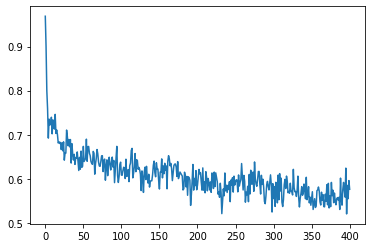

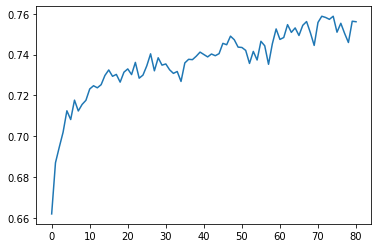

0.5693025588989258
0.572330117225647
0.5539133548736572
0.5564968585968018
0.5689752697944641
accuracy: 0.7505461267013948
0.5495147705078125
0.566257894039154
0.5327198505401611
0.5147913098335266
0.5638380646705627
accuracy: 0.7526466140144513


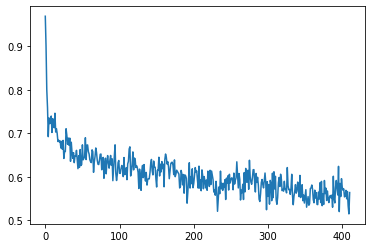

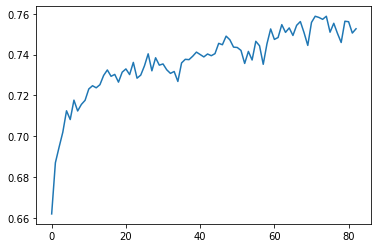

0.5803619027137756
0.5407892465591431
0.5534267425537109
0.5763168334960938
0.5709384083747864
accuracy: 0.7614686607292892
0.52191561460495
0.5790956020355225
0.5164994597434998
0.6048861145973206
0.5690124034881592
accuracy: 0.7646614014451353


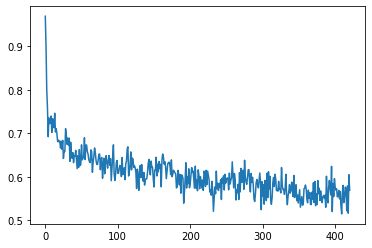

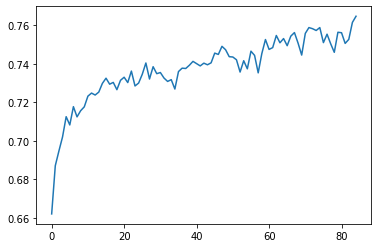

0.5392094850540161
0.577562153339386
0.5585881471633911
0.5534891486167908
0.53778076171875
accuracy: 0.7630650310872122
0.552444338798523
0.532039225101471
0.5118576884269714
0.5291512608528137
0.5185086727142334
accuracy: 0.764577381952613


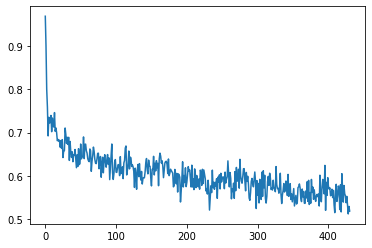

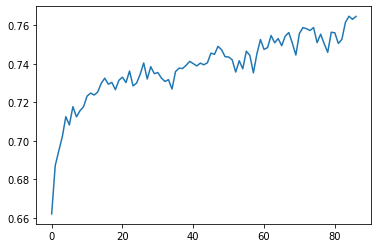

0.5796574354171753
0.5294304490089417
0.5504151582717896
0.5434828996658325
0.5168977379798889
accuracy: 0.765501596370358
0.5130727291107178
0.5230889320373535
0.5493130683898926
0.5444490313529968
0.537401020526886
accuracy: 0.7637371870273904


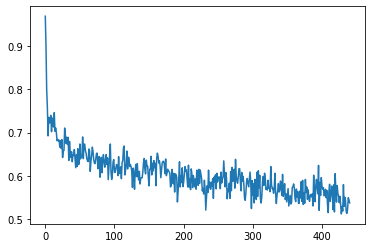

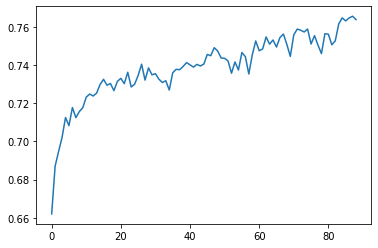

0.5456956624984741
0.5580956935882568
0.515590488910675
0.5931746959686279
0.530357301235199
accuracy: 0.7528986724920181
0.5883540511131287
0.5224169492721558
0.5799734592437744
0.5450666546821594
0.5125740170478821
accuracy: 0.7555032767602083


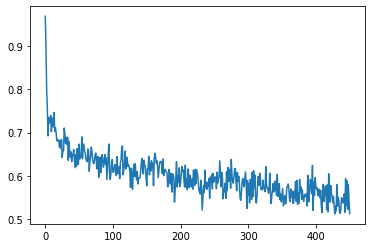

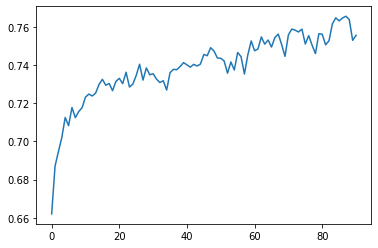

0.5625558495521545
0.5501728653907776
0.5509871244430542
0.5473629832267761
0.5728903412818909
accuracy: 0.7607124852965889
0.5606473684310913
0.5551111698150635
0.5178370475769043
0.5628869533538818
0.5612661242485046
accuracy: 0.7673500252058477


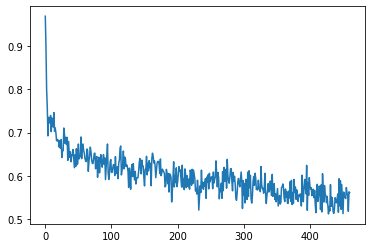

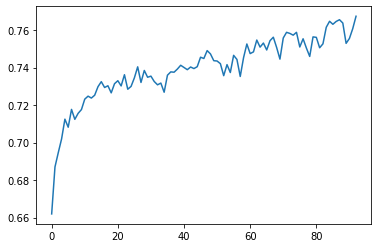

0.5521882772445679
0.5381957292556763
0.5299659967422485
0.5553486347198486
0.5677510499954224
accuracy: 0.7668459082507142
0.5787312388420105
0.539095938205719
0.5614018440246582
0.5075851678848267
0.5514488816261292
accuracy: 0.7683582591161149


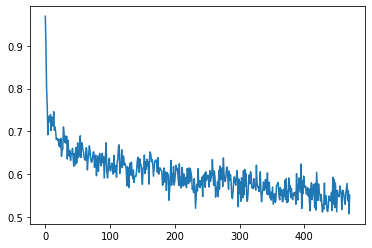

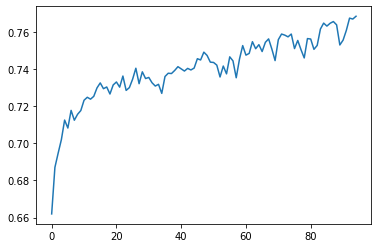

0.5516563057899475
0.5163426399230957
0.5416396260261536
0.525353193283081
0.5285547971725464
accuracy: 0.7676861031759368
0.5282890200614929
0.5273985266685486
0.5408572554588318
0.4887658953666687
0.5430833697319031
accuracy: 0.7720551167870946


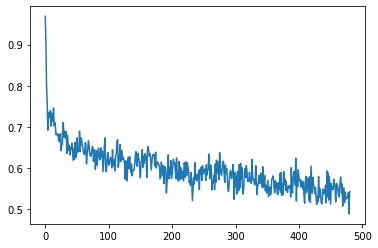

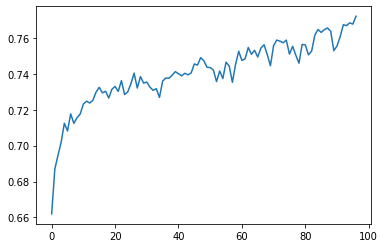

In [116]:
counter = []
teststopc = []
loss_history = [] 
for it in range(10000):
    
    example_batch = next(iter(train_dataloader))
    anchor = example_batch[0]
    positive = example_batch[1]
    negative = example_batch[2]

    optimizer.zero_grad()

    output1, output2, output3 = net(anchor, positive, negative)

    loss = triplet_loss(output1, output2, output3, 1) # best margin: 60
    
    print(loss.item())
    counter.append(it)
    loss_history.append(loss.item())

    loss.backward()

    optimizer.step()
    
    if it%5 == 0:
        summe = 0
        for i in range(X_test.shape[0]):
            img0, img1, img2 = net(torch.Tensor(allVectors[X_test[i, 0]+'.jpg']), torch.Tensor(allVectors[X_test[i, 1]+'.jpg']), torch.Tensor(allVectors[X_test[i, 2]+'.jpg']))
            summe += test_prediction(img0, img1, img2)
        stopc = summe/X_test.shape[0]
        teststopc.append(stopc)
        print("accuracy:", stopc)

    if it%10 == 0:
        plt.plot(loss_history)
        plt.show()
        plt.plot(teststopc)
        plt.show()
    if stopc > 0.77: # best stopc: 0.75
        break


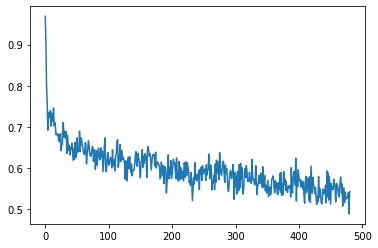

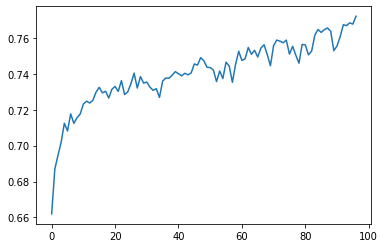

In [117]:

plt.plot(counter, loss_history)
plt.show()
plt.plot(teststopc)
plt.show()


In [118]:
summe = 0
for i in range(X_data.shape[0]):
    img0, img1, img2 = net(torch.Tensor(allVectors[X_data[i, 0]+'.jpg']), torch.Tensor(allVectors[X_data[i, 1]+'.jpg']), torch.Tensor(allVectors[X_data[i, 2]+'.jpg']))
    summe += test_prediction(img0, img1, img2)
print(summe)
print(X_data.shape[0])

37959
47612


In [119]:
X_test = pd.read_csv('test_triplets.txt', delimiter=' ', dtype=str)
X_test = X_test.to_numpy()
print(X_test.shape)
test_labels = np.empty(1)

for i in range(X_test.shape[0]):
    img0, img1, img2 = net(torch.Tensor(allVectors[X_test[i, 0]+'.jpg']), torch.Tensor(allVectors[X_test[i, 1]+'.jpg']), torch.Tensor(allVectors[X_test[i, 2]+'.jpg']))
    test_labels = np.append(test_labels, test_prediction(img0, img1, img2))

print(test_labels.shape)
print(X_test.shape)


(59543, 3)
(59544,)
(59543, 3)


In [120]:
test_labels = test_labels.astype(int)
np.set_printoptions(suppress=True)
np.savetxt('submission_3.csv', test_labels, fmt='%i')
print('done')

done


In [121]:
print(test_labels.shape)

(59544,)


In [122]:
print(test_labels)

[241   0   0 ...   1   1   0]
